# Integración de las ecuaciones de Lorenz

Los módulos a utilizar son:

In [13]:
include("Taylor.jl")
using TS

In [14]:
include("Lorenz.jl")
using LZ

In [15]:
using PyPlot
using PyCall
plt = PyPlot

PyPlot

En particular, el módulo `LZ` es el central para este proyecto. Vemos que está adecuadamente documentado:

In [4]:
?LZ

search: leading_zeros LZ finalize finalizer serialize Serializer



## LZ

Módulo que resuelve las ecuaciones de Lorenz clásicas

`dx/dt = σ(y-x),` `dy/dt = rx - y - xz,` `dz/dt = xy -bz.`

Donde r, σ, b son parámetros reales positivos.

La solución se hace por medio del método de Taylor con polinomios de Taylor de grado indicado por el usuario.

Véase las funciones

```julia
lorenz
diflorenz
taylor_lorenz
jacobian
lorenz_all
conteo_fractal
dim_fractal_cajas
```


Las múltiples funciones en el módulo se irán explicando a continuación. La primera consiste en un integrador que utiliza el método de Taylor para resolver un sistema de Lorenz con condiciones iniciales $(x_0, y_0, z_0)$ y en un intervalo temporal $t\in [t_0, t_f]$:

In [5]:
?lorenz

search: lorenz lorenz_all diflorenz taylor_lorenz set_bigfloat_precision



## Integrador de las ecuaciones de Lorenz

```
	lorenz(t0,tf,x0,y0,z0,r,σ,b,p)
```

Resuelve las ecuaciones de Lorenz con parámetros `r`, `σ`, `b` y condiciones iniciales `(x0,y0,z0)` del tiempo inicial `t0` al tiempo final `tf`. Las solución se hace mediante el método de Taylor con polinomios de Taylor hasta orden `p`.

Devuelve cuatro listas `t, x, y, z` con las soluciones.

### Ejemplo:

Para obtener la solución del sistema con parámetros `r, σ, b = 28.0, 10.0, 8/3`, del tiempo inicial `t0 = 0.0` al tiempo final `tf = 100.0` con condiciones iniciales `(x0, y0, z0) = (0.1, 0.1, 0.1)` con series de Taylor a orden `p = 20`.

```julia
t, x, y, z = lorenz(0.0, 100.0, 0.1, 0.1, 0.1, 28.0, 10.0, 8/3, 20)
```


Siguiendo al ejemplo de la documentación podemos resolver inmediatamente un sistema como

In [4]:
r, σ, b = 28, 10, 8/3
t, x, y, z = lorenz(0.0, 1000.0, 0.1, 0.1, 0.1, r, σ, b, 20);

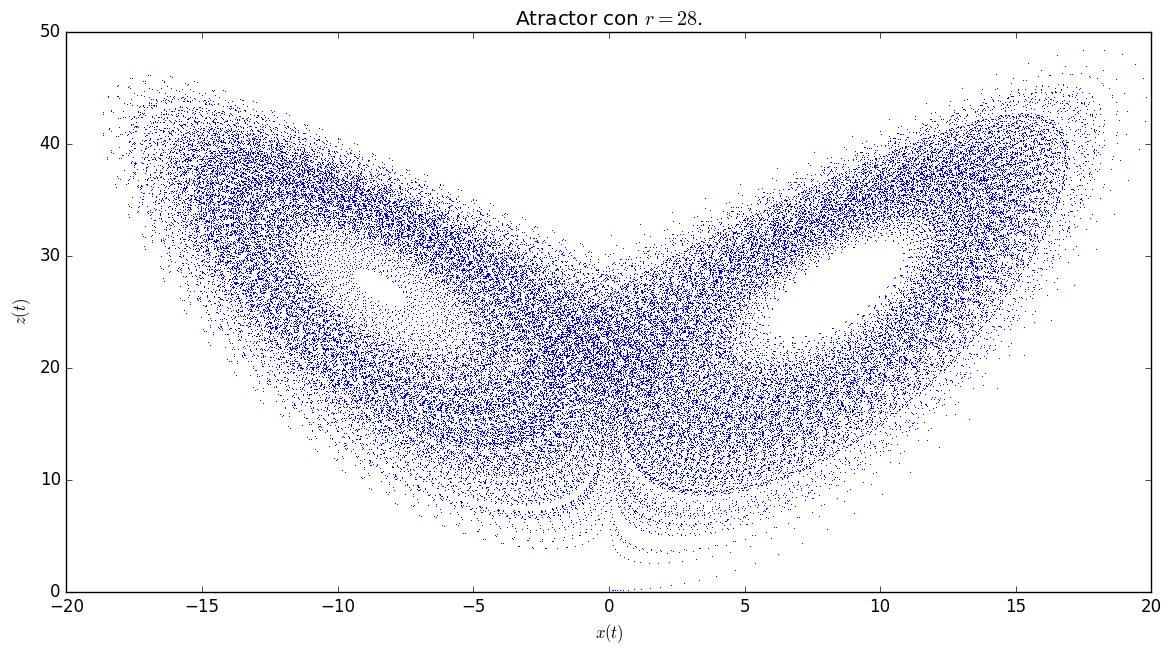

In [5]:
fig = figure("taylor_solution", figsize=(14,7))
plt.plot(x,z, ",");
plt.ylabel(L"$z(t)$");
plt.xlabel(L"$x(t)$");
plt.title(L"Atractor con $r = 28$.");
show()

# Cálculo de los exponentes de Lyapunov usando las ecuaciones variacionales

La matriz jacobiana del sistema de Lorenz es

$$J(t) = \begin{pmatrix}
-\sigma & \sigma & 0\\
r-z(t) & -1 & -x(t)\\
y(t) & x(t) & -b
\end{pmatrix}$$

Las ecuaciones variacionales son

$$\delta \dot{\vec{X}} = J(\vec{X}(t))\cdot \delta \vec{X}$$

Éstas determinan la evolución de perturbaciones $\delta \vec{X}$ alrededor de una trayectoria integrada $\vec{X}(t)$. De manera formal, los exponentes de Lyapunov son una cantidad que caracteriza la tasa de *separación* entre dos trayectorias cercanas. Se encuentra que en el espacio fase, dos trayectorias con separación inicial $\delta\vec{Z_0}$ divergen por una relación

$$|\delta\vec{Z}(T)|\approx e^{\lambda t}|\delta\vec{Z_0}|$$

La cantidad $\lambda$ el el exponente de Lyapunov que es

$$\lambda = \lim_{t\to\infty} \lim_{\delta Z\to 0} \frac{1}{t}\,\log\frac{|\delta\vec{Z}(t)|}{|\delta \vec{Z_0}|}$$

Para un sistema continuo con ecuación de evolución $f^t$ en $n$ dimensiones hay un espectro de exponentes de Lyapunov: $\lambda_1, \lambda_2, \ldots, \lambda_n$. El jacobiano es justamente la derivada

$$J(t) = \frac{df^t(x)}{dx}\Big|_{x_0}$$

También, notamos que las ecuaciones variacionales tienen una solución formal como

$$\delta \vec{X}(t) = \exp\left( \int_0^t\,J(\vec{X}(s))\,ds\right)\,\delta\vec{X_0}$$

Por lo que podemos ver que 

$$\lambda_i =\lim_{t\to \infty} \frac{\text{eigvals}\left( \int_0^t\,J(\vec{X}(s))\,ds \right)}{t}$$

Es decir, hay que integrar el Jacobiano sobre una trayectoria, sacar los eigenvalores y dividir entre el tiempo. Resulta que esto no es del todo cierto. Existe el Teorema de Oseledec que dice que hay que simetrizar este Jacobiano para garantizar la existencia de los eigenvalores. De todos modos resulta muy sencillo extenderse a 

$$\lambda_i = \lim_{t\to \infty} \frac{\text{eigvals}\left( \int_0^t\,\left\lbrace J(\vec{X}(s)) + J^T(\vec{X}(s))\right\rbrace\,ds \right)}{2t}$$

La solución formal al problema queda clara pero hay otra dificultad. No se puede simplemente integrar los jacobianos y sacar eigenvalores con la funcion de `Julia`, `eigvals` porque suponga que se tiene un eigenvalor positivo. Entonces, los $\delta \vec{X}$ van a alinearse fuertemente con la dirección asociada a este eigenvalor. Eso hace que las otras direcciones se "aplasten". Por lo tanto, computacionalmente, este no es un buen método para encontrar los exponentes. Sin embargo, siguiendo a **Benettin** podemos reescalar cada número de pasos. Esto es un proceso de ortogonalización de Gramm-Schmidt.

La idea intuitiva es que se tiene un volumen expandido por $n$ vectores a través de un elipsoide. Entonces, el efecto de las ecuaciones variacionales es cambiar este volumen en la forma determinada por los eigenvectores de la matrix jacobiana a ese instante de tiempo. El elipsoide queda deformado y si un exponente es positivo y particularmente mayor que los demás se "aplana" el elipsoide en esta dirección. En este momento lo que se hace es registrar el cambio de volumen y reescalar de tal manera que que los vectores evolucionados sean nuevamente ortonormales. Como se lleva un registro de cuánto se modificó el volumen, al final podemos decir cuánto se modificó el volumen con respecto a la primera escala. Esta cantidad debe ser proporcional a 

$$e^{(\lambda_1 + \lambda_2 + \ldots + \lambda_n)t}$$

De donde es posible sacar los eigenvalores de manera iterativa. El algoritmo es relativamente sencillo de construir y se hace en la siguiente función:

In [6]:
?lorenz_all

search: lorenz_all



## Integrador de trayectoria y exponentes de Lyapunov para las ecuaciones de Lorenz

```
	lorenz_all(t0,tf,x0,y0,z0,r,σ,b,p,TOL)
```

Resuleve el sistema Lorenz parametrizado con `r, σ, b` y condiciones iniciales `x0, y0, z0` integrando desde `t0 a tf`. `p` es el orden entero de los `Taylor`'s utilizados en el cálculo y `TOL` es un  parámetro que indica la convergencia de los exponentes de Lyapunov. Devuelve

`tl, xl, yl, zl, xtl, ytl, ztl, lambda1l, lambda2l, lambda3l, flag`

donde `tl` es una lista de tiempos entre `t0` y `tf`. `xl, yl, zl` son las listas que contienen la trayectoria integrada a cada tiempo de la lista `tl`. `xtl, ytl y ztl` son listas con los `Taylor`'s de cada tiempo de `tl`. `lambda1l, lambda2l, lambda3l` son listas de los tres exponentes calculados a cada tiempo de `tl`. `flag` es un booleano que indica si los exponentes de Lyapunov convergieron en el tiempo de integración.

El cálculo de los exponentes se hace por medio de las ecuaciones variacionales, resolviéndolas por el método de Taylor. Se hace otrogonalización de Gramm-Schmidt en cada paso para evitar que los eigenvectores se "aplanen" en la dirección de máximo crecimiento.

### Ejemplo

Suponga que se quiere conocer los exponentes de Lyapunov del sistema Lorenz parametrizado por `r, σ, b = 28, 10, 8/3`. Entonces se integra desde un tiempo `t0=0` a `tf=1000` y con tolerancia `TOL = 1.0e-4`. Las condiciones iniciales se establecen como `x0, y0, z0 = 0.1, 0.1, 0.1`. Por lo tanto, al correr

```julia
sol = lorenz_all(0.0, 1000.0, 0.1, 0.1, 0.1, 28.0, 10.0, 8/3, 20, 1.0e-4)
flag, l1, l2, l3 = sol[end][end], sol[end-1][end], sol[end-2], sol[end-3][end]
```

`flag` nos dice si los exponentes convergieron dentro del rango de toleracia `TOL` y las `l1, l2, l3` son los valores finales de los exponentes de Lyapunov.


Ahora vamos a calcular los exponentes de Lyapunov para un sistema con parámetros como vienen en la referencia (*Numerical Calculation of Lyapunov Exponents* - **Marco Sandri**): $r, \sigma, b = 45.92, 16.0, 4.0$ y condiciones iniciales $x_0, y_0, z_0 = 19.0, 20,0 50,0$. En esta referencia se tiene:

$$\lambda_1, \lambda_2, \lambda_2 = 1.48245, -0.0001195, -22.4654$$

Nuestro cálculo procede de la siguiente manera:

In [4]:
r, σ, b = 45.92, 16.0, 4.0
tl, xl, yl, zl, xtl, ytl, ztl, lambda1l, lambda2l, lambda3l, flag = lorenz_all(0.0, 1000.0, 19.0, 20.0, 50.0, r, σ, b, 20, 1.0e-4, 0);

365.466257 seconds (2.58 G allocations: 282.493 GB, 25.80% gc time)
370.706600 seconds (2.56 G allocations: 280.292 GB, 26.82% gc time)


Podemos ahora graficar $1/t$ y $\lambda_i(t)$ como en la siguiente gráfica:

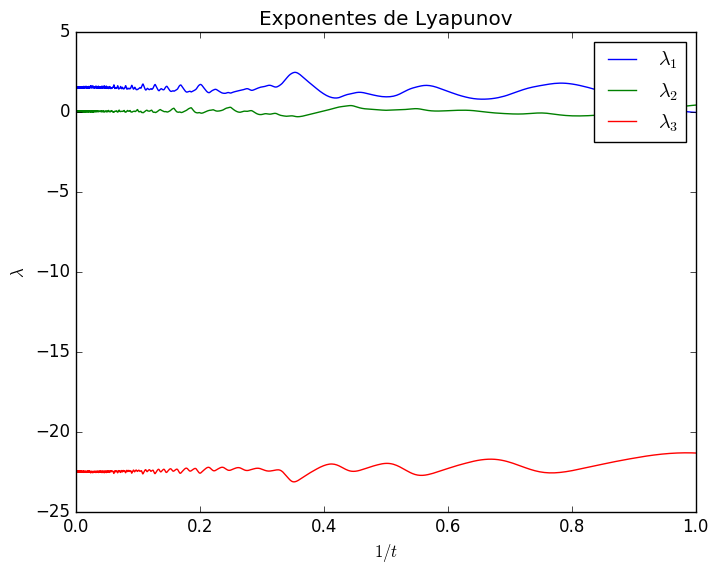

In [13]:
fig = figure("figsize=(14,7)")
plt.xlim(0,1)
plt.plot(1 ./ tl, lambda1l, label = L"\lambda_1");
plt.plot(1 ./ tl, lambda2l, label = L"\lambda_2");
plt.plot(1 ./ tl, lambda3l, label = L"\lambda_3");
plt.legend();
plt.ylabel(L"$\lambda$");
plt.xlabel(L"$1/t$");
plt.title("Exponentes de Lyapunov");
show()

Encontramos que, ortogonalizando cada paso:

In [6]:
l1, l2, l3 = lambda1l[end], lambda2l[end], lambda3l[end]

(1.4949069071301537,5.247395911086754e-5,-22.494959381089156)

$$\lambda_1, \lambda_2, \lambda_2 = 1.49491, -0.0000525, -22.4950$$

c.f. con **Sandri**:

$$\lambda_1, \lambda_2, \lambda_2 = 1.48245, -0.0001195, -22.4654$$

Como bien se ve, la diferencia está fundamentalmente en el segundo exponente donde se tiene la mitad del reportado. Esto hizo que nos confundiéramos un poco porque lo natural es creer que nuestro método debe tener algún detalle incorrecto. Sin embargo después de revisar múltiples veces el código se encontró que esto no es el caso.

Recordemos que nuestros métodos de solución utilizan a Taylor con paso variable tanto en la solución del sistema de Lorenz como en el de las ecuaciones variacionales. Esto no sucede para la referencia donde se hace como siempre por RK4 ambos.

Una muy buena manera de revisar que se esté haciendo lo correcto es sumando los eigenvalores. Para el sistema de Lorenz, los elementos diagonales son idependientes del tiempo, así que sabemos que la traza debe cumplir:

$$-(\sigma + b + 1) = \lambda_1 + \lambda_2 + \lambda_3$$

Para nuestro caso, la traza debe ser exactamente $-21$ y en efecto hallamos:

In [7]:
l1 + l2 + l3

-20.999999999999893

Mientras que para la referencia,

In [14]:
1.48245 - 0.0001195 - 22.4654

-20.9830695

Es decir, la referencia ni siquiera se acerca a la segunda cifra decimal. Esto nos reestablece la confianza en nuestro método. E incluso es algo importante señalar que este hecho de comparar los exponentes de Lyapunov con la traza es algo que no se suele hacer en referencias donde se hacen cálculos numéricos. La idea surgió de una referencia más bien teórica. Por lo tanto, es importante realizar este tipo de pruebas como veremos en otro ejemplo a continuación.

Sin embargo, antes puede ser ilustrativo ver cuál es exactamente el efecto de ortogonalizar cada paso. Esto es otro detalle que hace la referencia de Sandri: se está ortogonalizando cada 800 pasos donde cada paso es un intervalo fijo de 0.02s. Nosotros ni siquiera tenemos un intervalo fijo pero podemos ver si el efecto de ortogonalizar cada $n$ pasos mejora el tiempo de ejecución. De manera inicial un podría creer que sí pero resulta sorprendente encontrar que

In [15]:
r, σ, b = 45.92, 16.0, 4.0
@time tl, xl, yl, zl, xtl, ytl, ztl, lambda1l, lambda2l, lambda3l, flag = lorenz_all(0.0, 1000.0, 19.0, 20.0, 50.0, r, σ, b, 20, 1.0e-4, 0);
@time tl2, xl2, yl2, zl2, xtl2, ytl2, ztl2, lambda1l2, lambda2l2, lambda3l2, flag2 = lorenz_all(0.0, 1000.0, 19.0, 20.0, 50.0, r, σ, b, 20, 1.0e-4, -1);

363.529532 seconds (2.58 G allocations: 282.404 GB, 28.15% gc time)
359.604495 seconds (2.55 G allocations: 279.793 GB, 27.58% gc time)


Este efecto ya lo habíamos antes encontrado en el método de Taylor: reducir el orden de los polinomios no necesariamente implica que el tiempo se reduce ya que el método establece que ahora los pasos de tiempo deben ser más pequeños y se terminan haciendo más. Hay un balance de orden `p`y tiempo de ejecución que nosotros encontramos que era ideal en `p=20`. En este caso se tiene algo completamente análogo. Puesto que no se está ortonormalizando, el programa se tarda mucho más en resolver la ecuación variacional por Taylor, lo cual hace que aumente considerable el tiempo de ejecución.

A continuación se analiza la convergencia de los resultados sin ortonormalizar:

In [16]:
l12, l22, l32 = lambda1l2[end], lambda2l2[end], lambda3l2[end-1]

(1.4988069559087438,1.4995211688064536,1.4990100769629036)

Hacemos una prueba rápida con la traza:

In [17]:
l12 + l22 + l32

4.497338201678101

Algo debe estar terriblemente mal:

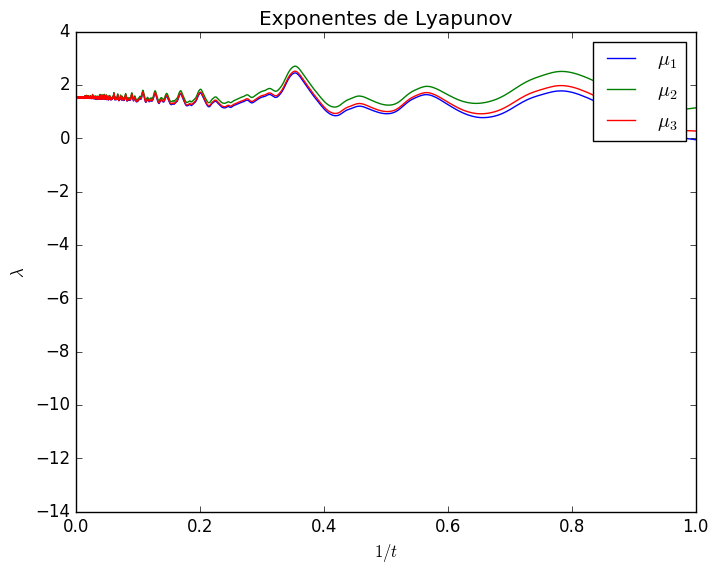

In [18]:
fig = figure("figsize=(14,7)")
plt.xlim(0,1)
plt.plot(1 ./ tl2, lambda1l2, label = L"\mu_1");
plt.plot(1 ./ tl2, lambda2l2, label = L"\mu_2");
plt.plot(1 ./ tl2, lambda3l2, label = L"\mu_3");
plt.legend();
plt.ylabel(L"$\lambda$");
plt.xlabel(L"$1/t$");
plt.title("Exponentes de Lyapunov");
show()

Como se ve, si se hace el caso drástico de no ortonormalizar, todos los exponentes tienen al mayor muy rápidamente $\lambda \approx 1.48$. Esto fue un caso sumamente dramático: ¿qué tal se opta por ortonormalizar cada 100 pasos por ejemplo?

In [19]:
r, σ, b = 45.92, 16.0, 4.0
@time tl, xl, yl, zl, xtl, ytl, ztl, lambda1l, lambda2l, lambda3l, flag = lorenz_all(0.0, 1000.0, 19.0, 20.0, 50.0, r, σ, b, 20, 1.0e-4, 0);
@time tl2, xl2, yl2, zl2, xtl2, ytl2, ztl2, lambda1l2, lambda2l2, lambda3l2, flag2 = lorenz_all(0.0, 1000.0, 19.0, 20.0, 50.0, r, σ, b, 20, 1.0e-4, 100);

432.010378 seconds (2.58 G allocations: 282.404 GB, 27.95% gc time)
416.304573 seconds (2.56 G allocations: 280.292 GB, 28.68% gc time)


In [20]:
l12, l22, l32 = lambda1l2[end], lambda2l2[end], lambda3l2[end-1]

(1.502360532061687,0.005500365475922311,-22.465898719204983)

In [21]:
l12 + l22 + l32

-20.958037821667375

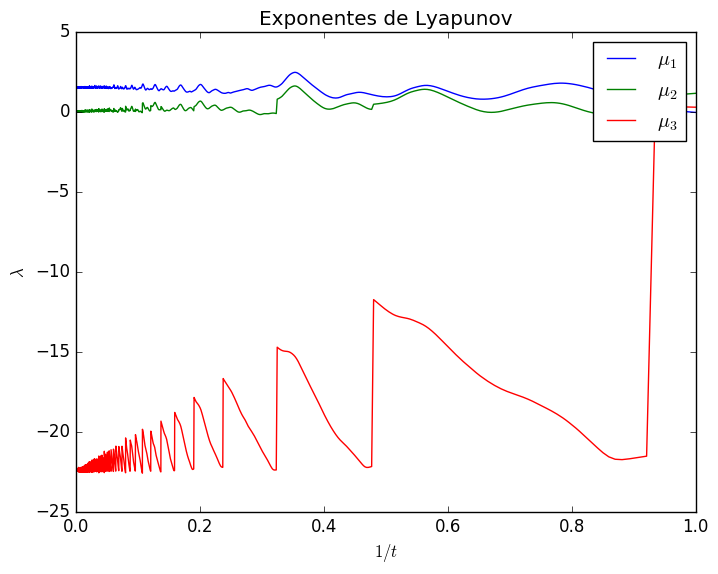

In [22]:
fig = figure("figsize=(14,7)")
plt.xlim(0,1)
plt.plot(1 ./ tl2, lambda1l2, label = L"\mu_1");
plt.plot(1 ./ tl2, lambda2l2, label = L"\mu_2");
plt.plot(1 ./ tl2, lambda3l2, label = L"\mu_3");
plt.legend();
plt.ylabel(L"$\lambda$");
plt.xlabel(L"$1/t$");
plt.title("Exponentes de Lyapunov");
show()

Comparamos para cuando ortonormalizamos cada paso:

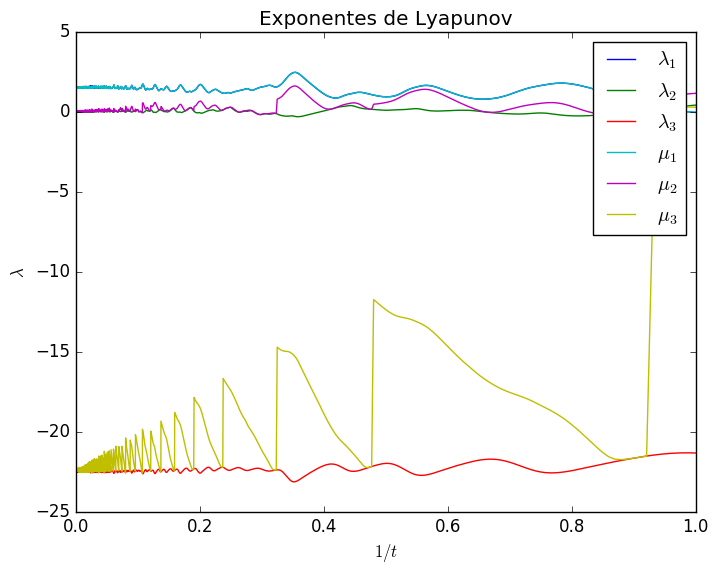

In [23]:
fig = figure("figsize=(14,7)")
plt.xlim(0,1)
plt.plot(1 ./ tl, lambda1l, label = L"\lambda_1");
plt.plot(1 ./ tl, lambda2l, label = L"\lambda_2");
plt.plot(1 ./ tl, lambda3l, label = L"\lambda_3");
plt.plot(1 ./ tl2, lambda1l2, label = L"\mu_1");
plt.plot(1 ./ tl2, lambda2l2, label = L"\mu_2");
plt.plot(1 ./ tl2, lambda3l2, label = L"\mu_3");
plt.legend();
plt.ylabel(L"$\lambda$");
plt.xlabel(L"$1/t$");
plt.title("Exponentes de Lyapunov");
show()

Claramente podemos concluir que tanto por la indiferencia de tiempo como por la convergencia, es más conveniente ortogonalizar cada paso.

Este efecto de tener resultados distintos a los reportados en las referencias se repite en *A differential algorithm for the Lyapunov spectrum* - **Stachowiak, Szydlowsku** donde se compara un algoritmo diferencial propuesto con el método usual de integrar la ecuación de movimiento y usar GS. En este caso, los parámetros son $r,\sigma, b = 28, 10, 8/3$; condiciones iniciales $x_0, y_0, z_0 = 10$ y un intervalo de integración de $t\in[0,1000]$. Ellos encuentran que

$$\lambda_1, \lambda_2, \lambda_3 = -14.5676, -0.0010078, 0.901931$$

Nosotros realizamos el cálculo:

In [25]:
sol3 = lorenz_all(0.0, 1000.0, 10.0, 10.0, 10.0, 28.0, 10.0, 8/3, 20);

Nótese que en este caso la traza es

In [26]:
-(10 + 1 + 8/3)

-13.666666666666666

Nosotros tenemos que la suma de los exponentes es

In [27]:
sol3[end-3][end] + sol3[end-2][end] + sol3[end-1][end]

-13.666666666666758

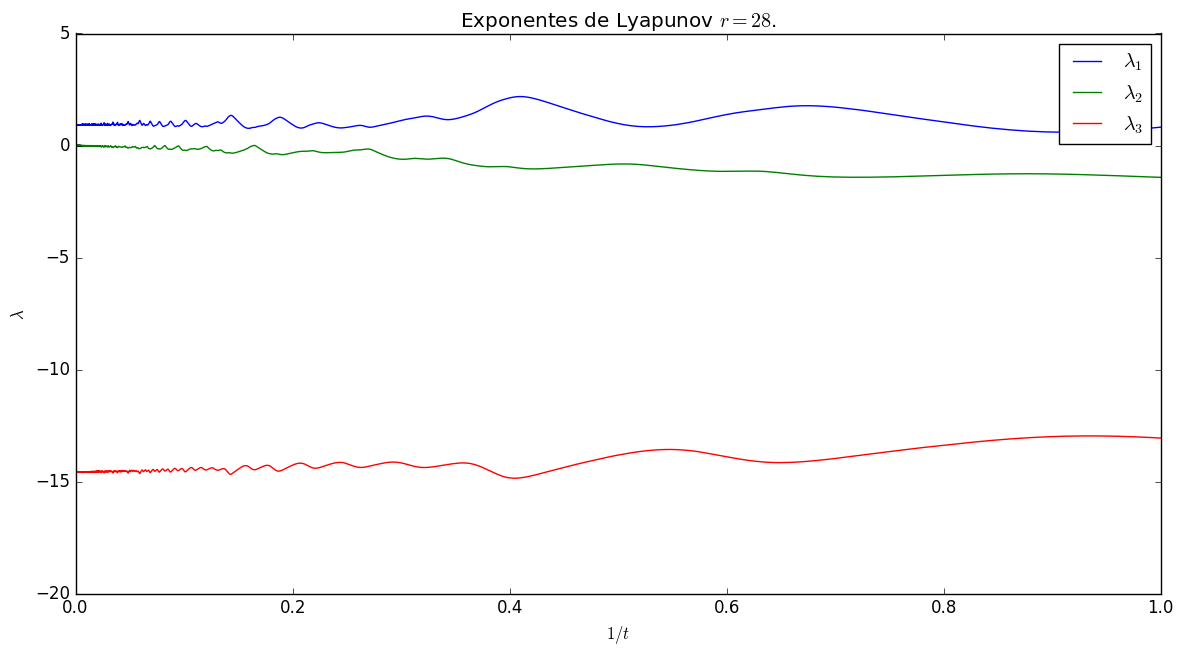

In [31]:
fig = figure("taylor_solution", figsize=(14,7))
plt.plot(1 ./ sol3[1],sol3[end-3],label = L"\lambda_1");
plt.plot(1 ./ sol3[1],sol3[end-2],label = L"\lambda_2");
plt.plot(1 ./ sol3[1],sol3[end-1],label = L"\lambda_3");
plt.xlim(0,1)
plt.legend();
plt.ylabel(L"$\lambda$");
plt.xlabel(L"$1/t$");
plt.title(L"Exponentes de Lyapunov $r = 28$.");
show()

In [29]:
sol3[end-3][end], sol3[end-2][end], sol3[end-1][end]

(0.9132252332189362,-0.0013971393526865004,-14.578494760533008)

Entonces podemos comparar nuestros exponentes calculados con los de la referencia:

$$\lambda_1, \lambda_2, \lambda_3 = -14.5785, -0.0013971, 0.913225$$

c.f. **Stachowiak, Szydlowsku**

$$\lambda_1, \lambda_2, \lambda_3 = -14.5676, -0.0010078, 0.901931$$

Nótese nuevamente que la referencia no se acerca al valor deseado de la traza como nostros:

In [34]:
-14.5676 - 0.0010078 + 0.901931

-13.666676800000001

Todo lo anterior básicamente nos da muchas bases para ver que este método de calcular exponentes de Lyapunov via Taylor está dando resultados  que demuestran que los calculados antes en la literatura no tienen confiablidad a partir de la segunda o tercera cifra decimal. El cálculo tan preciso de exponentes de Lyapunov tal vez no sea un área de gran importancia pero sí es importante notarlo.

# Variación de los parámetros

Con lo anterior podemos hacer un cálculo de los distintos exponentes de Lyapunov según como variamos el parámetro $r$ en las ecuaciones de Lorenz. El cálculo de los exponentes es directo pero como toma bastante tiempo si se trata de muchos, se guardaron en archivos para poder ir calculando progresivamente. Por ejemplo, fijando los parámetros $\sigma, b = 10, 8/3$ tenemos a las $r\in[0, 30]$:

In [16]:
file1 = open("l_exponents_0_30.tsv", "r")
l0_30 = readdlm(file1)
a, l1, l2, l3 = l0_30[:,1], l0_30[:,2], l0_30[:,3], l0_30[:,4];

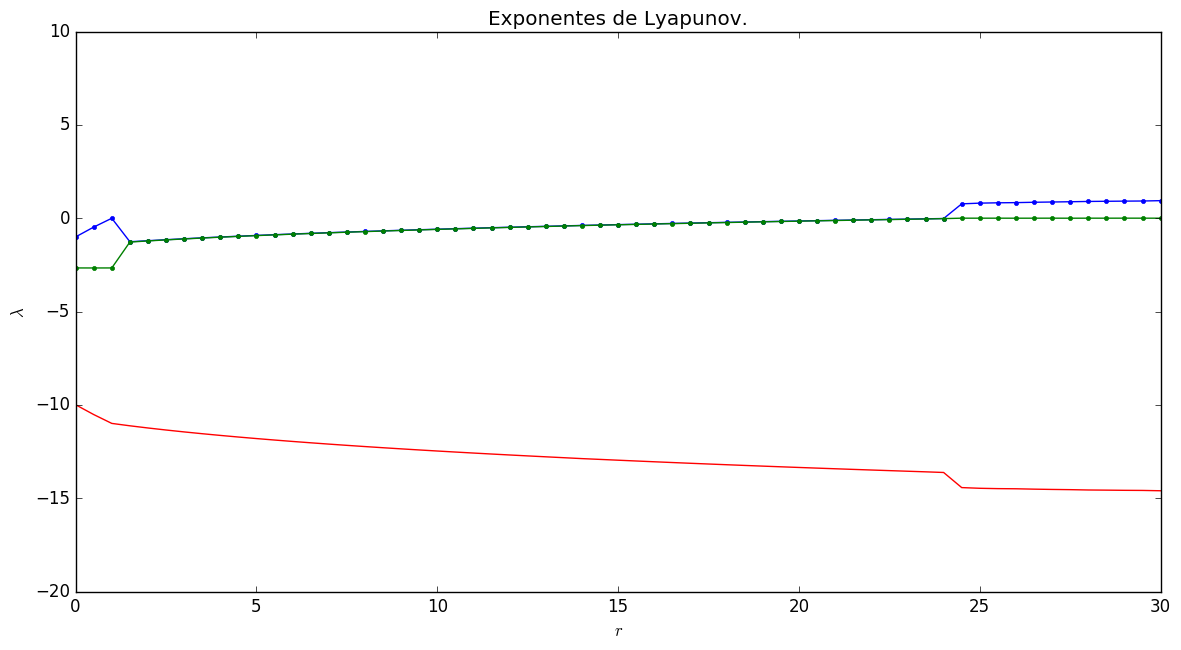

In [23]:
fig = figure("lyapunov_exps", figsize=(14,7))
plt.plot(a,l1);
plt.plot(a,l2);
plt.plot(a,l3);
plt.ylim(-20,10)
plt.xlabel(L"$r$");
plt.ylabel(L"$\lambda$");
plt.title("Exponentes de Lyapunov.");
show()